This is a version of object detection that goes through the thought process more in depth.

##### Step 1. Loading the Input image/s

In [1]:
# import dependencies 
import os 
os.environ ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# SAM/OpenCLIP dependencies
import torch
import torchvision
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image as Image_Open
from PIL import Image
import open_clip

# COCO dependencies
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import json

Load COCO and initialize the labels from Val 2017 annotations

In [2]:
# Loading COCO
dataDir='..'
dataType='val2017'
annFile='{}/coco/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


In [3]:
# display COCO categories and store them into array 'labels'. Tokenize the labels using OpenCLIP
cats = coco.loadCats(coco.getCatIds())
labels = [(cat['id'], cat['name']) for cat in cats]
labels_id = {id : label for id, label in labels}
print(labels_id)

# Tokenize the labels
labels_tokenized = open_clip.tokenize(["This is " + desc[1] for desc in labels])

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

Load input image using COCO

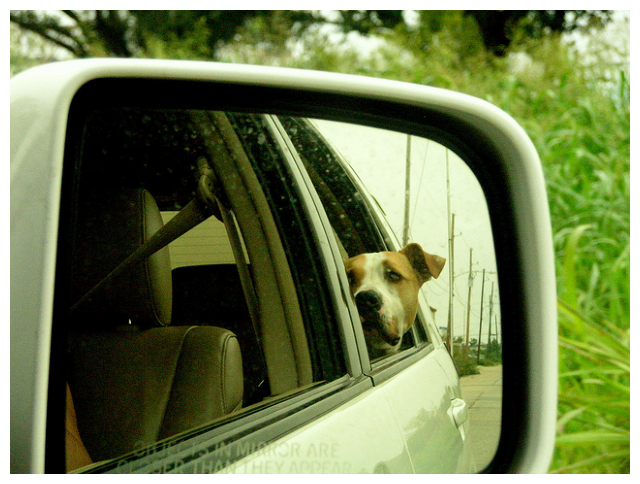

In [19]:
# randomly sample an image from COCO Val split 2017
catIds = coco.getCatIds(catNms=['person','dog']);
imgIds = coco.getImgIds(catIds=catIds );

# imgIds = coco.getImgIds(imgIds = [324158]) // uncomment to get a specific image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
image_id = img['id']

# load and display image
image = io.imread(img['coco_url']) 

# tempImg to be cropped for some functions
tempImg = Image.fromarray(image) 

plt.imshow(tempImg)
plt.axis('off')
plt.show()

In [8]:
print(image_id)

311190


Load input image locally

In [100]:
# load and display image
image = cv2.imread('images/dog.jpg') 
image_id = 999999
# convert image to be readable by SAM
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# tempImg to be cropped for some functions
tempImg = Image.fromarray(image)
plt.imshow(tempImg)
plt.axis('off')
plt.show() 

##### Step 2. Segment Anything Output

In [20]:
# Loading SAM Model
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Loading SAM Predictors
mask_generator = SamAutomaticMaskGenerator(
    model = sam,
    points_per_side = 32,
    points_per_batch = 64,
    pred_iou_thresh = 0.95,
    stability_score_thresh = 0.95,
    stability_score_offset = 1.0,
    box_nms_thresh = 0.7,
    crop_n_layers = 0,
    crop_nms_thresh = 0.7,
    crop_overlap_ratio = 100 / 1500,
    crop_n_points_downscale_factor = 1,
    point_grids = None,
    min_mask_region_area = 0,
    output_mode = "binary_mask",
) # automatic
predictor = SamPredictor(sam) # manual


# Loading OpenCLIP model
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

In [9]:
# functions for displaying mask/box
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
   
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [21]:
# Run automatic mask generation)
masks = mask_generator.generate(image)
length_masks = len(masks)

##### Step 3. Cropping the image depending on the SAM output (masks)

In [22]:
def get_cropped_image(mask):
    # convert the XYWH bounding box to LURD format
    bbox_xywh = masks[mask]['bbox'] # the SAM model returns the bounding box in xywh format
    bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2], 
    bbox_xywh[1] + bbox_xywh[3]] # convert the bounding box to LURD format
    
    # Crop the image using the bounding box coordinates
    cropped_image = tempImg.crop(bbox_lurd) 
    display_image = cropped_image.convert("RGB")
    cropped_image = transform(display_image).unsqueeze(0)
    
    return cropped_image, display_image

##### Step 4. Getting the output label prediction from openCLIP.

In [24]:
# Run through all the masks and then crop image to ask OpenClip "This is a photo of what?"
def get_mask_label(mask):    
    # crop the image AKA get the bounding box
    cropped_image, display_image = get_cropped_image(mask)
    
    # ask OpenClip "This is a photo of what?"
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(cropped_image).float()
        text_features = model.encode_text(labels_tokenized).float()
    
    # Normalize the features and calculate the dot product of each pair.
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    
    # Get the predicted label
    predicted_label_index = similarity.argmax()
    predicted_label = labels[predicted_label_index]
    
    # get the top 2 probabilities and labels
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(2, dim=-1)
    
    # return the highest probability label and its percentage
    return labels[top_labels[0][0].item()], top_probs[0][0].item()

In [25]:
print(get_mask_label(0))

((18, 'dog'), 0.9170454144477844)


In [26]:
# create a dictionary of labels and the corresponding probabilities
label_dict = []

# iterate through all the masks and get the top 2 labels for each mask
for mask in range(length_masks):
    label1, probability1 = get_mask_label(mask)
    label_dict.append({"image_id": image_id, "category_id": label1[0], 
                       "bbox": masks[mask]['bbox'], "score": probability1})

In [27]:
print(label_dict)

[{'image_id': 151962, 'category_id': 18, 'bbox': [0, 52, 564, 425], 'score': 0.9170454144477844}, {'image_id': 151962, 'category_id': 62, 'bbox': [154, 327, 86, 115], 'score': 0.3296777307987213}, {'image_id': 151962, 'category_id': 18, 'bbox': [346, 241, 103, 119], 'score': 0.9945135116577148}, {'image_id': 151962, 'category_id': 39, 'bbox': [558, 301, 81, 176], 'score': 0.27483227849006653}, {'image_id': 151962, 'category_id': 62, 'bbox': [158, 210, 109, 199], 'score': 0.7477949857711792}, {'image_id': 151962, 'category_id': 32, 'bbox': [465, 366, 42, 110], 'score': 0.07239484786987305}, {'image_id': 151962, 'category_id': 10, 'bbox': [57, 386, 27, 90], 'score': 0.18399953842163086}, {'image_id': 151962, 'category_id': 3, 'bbox': [213, 390, 202, 87], 'score': 0.32385191321372986}, {'image_id': 151962, 'category_id': 62, 'bbox': [166, 263, 101, 146], 'score': 0.738706111907959}, {'image_id': 151962, 'category_id': 56, 'bbox': [333, 0, 72, 26], 'score': 0.3186907172203064}, {'image_id'

xywh:  [558, 301, 81, 176] lurd:  [558, 301, 639, 477]
label:  39 , baseball bat
score:  0.27483227849006653


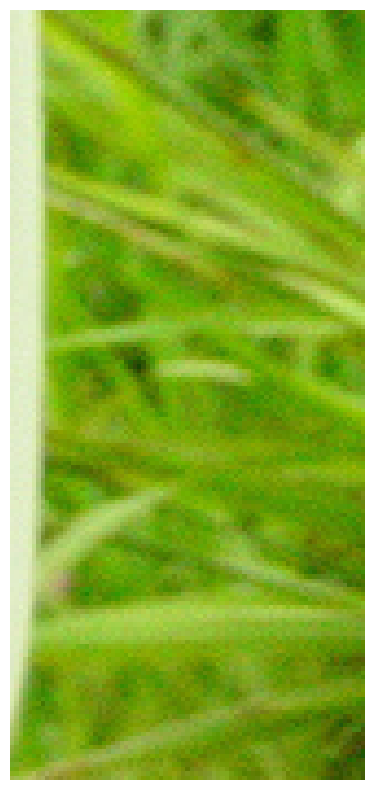

In [28]:
# check validity of labels
def check_label(label_id):
      bbox_xywh = label_dict[label_id]['bbox']
      # Convert the bounding box to LURD format
      bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2],bbox_xywh[1] + bbox_xywh[3]]
      print("xywh: ", bbox_xywh, "lurd: ", bbox_lurd)
      print("label: ", label_dict[label_id]["category_id"], ",", 
            labels_id.get(label_dict[label_id]["category_id"]))
      print("score: ", label_dict[label_id]["score"])

      cropped_image = tempImg.crop(bbox_lurd) # Crop the image using the bounding box coordinates
      cropped_image.convert("RGB")
      plt.imshow(cropped_image)
      plt.axis('off')
      plt.show() 

label_id = 0  
check_label(3)

In [45]:
import pickle
filename = f'label_dict_{image_id}.pkl'
folder_name = 'label_dicts_results'
file_path = os.path.join(folder_name, filename)
os.makedirs(folder_name, exist_ok=True)
with open(file_path, 'wb') as f:
    pickle.dump(label_dict, f)

In [94]:
with open(file_path, 'rb') as f:
    loaded_list = pickle.load(f)
print(loaded_list)
label_dict = loaded_list

[{'image_id': 253386, 'category_id': 18, 'bbox': [146, 25, 310, 306], 'score': 0.9947506785392761}, {'image_id': 253386, 'category_id': 18, 'bbox': [0, 0, 432, 332], 'score': 0.993509829044342}, {'image_id': 253386, 'category_id': 17, 'bbox': [0, 0, 55, 256], 'score': 0.2921299636363983}, {'image_id': 253386, 'category_id': 18, 'bbox': [309, 0, 190, 264], 'score': 0.4950629472732544}, {'image_id': 253386, 'category_id': 88, 'bbox': [0, 0, 82, 332], 'score': 0.2636736333370209}, {'image_id': 253386, 'category_id': 60, 'bbox': [21, 237, 61, 40], 'score': 0.16077135503292084}, {'image_id': 253386, 'category_id': 34, 'bbox': [0, 309, 17, 23], 'score': 0.2009756714105606}, {'image_id': 253386, 'category_id': 1, 'bbox': [309, 0, 54, 52], 'score': 0.17011983692646027}, {'image_id': 253386, 'category_id': 1, 'bbox': [89, 118, 33, 22], 'score': 0.1329345554113388}, {'image_id': 253386, 'category_id': 32, 'bbox': [419, 0, 80, 268], 'score': 0.112538181245327}, {'image_id': 253386, 'category_id':

In [23]:
# under label_dict() if a score is less than 50% then remove it
label_dict = [label for label in label_dict if label["score"] >= 0.5]

In [24]:
def is_contained(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    return x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2

label_dict.sort(key=lambda x: x['bbox'][2] * x['bbox'][3])

result = []
for i in range(len(label_dict)):
    keep = True
    for j in range(i + 1, len(label_dict)):
        if is_contained(label_dict[i]['bbox'], label_dict[j]['bbox']):
            keep = False
            break
    if keep:
        result.append(label_dict[i])

print(result)
label_dict = result

[{'image_id': 182805, 'category_id': 55, 'bbox': [552, 346, 61, 13], 'score': 0.9990777969360352}, {'image_id': 182805, 'category_id': 55, 'bbox': [0, 333, 50, 26], 'score': 0.8235262632369995}, {'image_id': 182805, 'category_id': 55, 'bbox': [209, 340, 81, 19], 'score': 0.765758216381073}, {'image_id': 182805, 'category_id': 57, 'bbox': [526, 230, 113, 128], 'score': 0.5055215358734131}, {'image_id': 182805, 'category_id': 23, 'bbox': [330, 192, 231, 166], 'score': 0.5717936754226685}, {'image_id': 182805, 'category_id': 18, 'bbox': [50, 0, 373, 358], 'score': 0.7365156412124634}, {'image_id': 182805, 'category_id': 18, 'bbox': [0, 0, 639, 233], 'score': 0.5226022601127625}, {'image_id': 182805, 'category_id': 28, 'bbox': [0, 5, 639, 336], 'score': 0.5405510067939758}]


In [25]:
result = []
for i in range(len(label_dict)):
    keep = True
    for j in range(len(label_dict)):
        if i != j and label_dict[i]['category_id'] == label_dict[j]['category_id'] and label_dict[i]['score'] < label_dict[j]['score']:
            keep = False
            break
    if keep:
        result.append(label_dict[i])

print(result)
label_dict = result

[{'image_id': 182805, 'category_id': 55, 'bbox': [552, 346, 61, 13], 'score': 0.9990777969360352}, {'image_id': 182805, 'category_id': 57, 'bbox': [526, 230, 113, 128], 'score': 0.5055215358734131}, {'image_id': 182805, 'category_id': 23, 'bbox': [330, 192, 231, 166], 'score': 0.5717936754226685}, {'image_id': 182805, 'category_id': 18, 'bbox': [50, 0, 373, 358], 'score': 0.7365156412124634}, {'image_id': 182805, 'category_id': 28, 'bbox': [0, 5, 639, 336], 'score': 0.5405510067939758}]


xywh:  [0, 52, 564, 425] lurd:  [0, 52, 564, 477]
label:  18 , dog
score:  0.9170454144477844


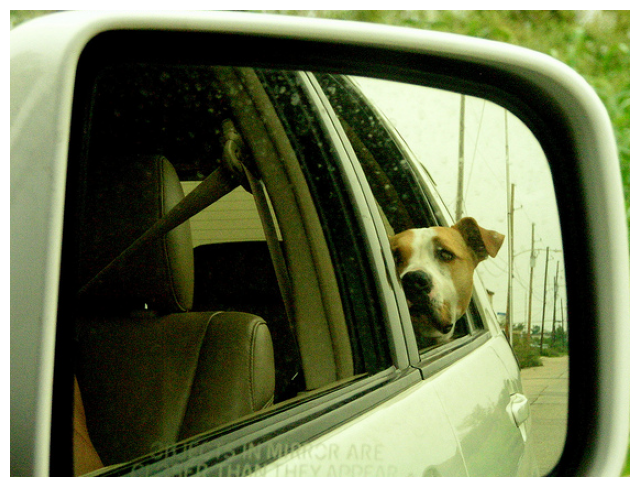

xywh:  [154, 327, 86, 115] lurd:  [154, 327, 240, 442]
label:  62 , chair
score:  0.3296777307987213


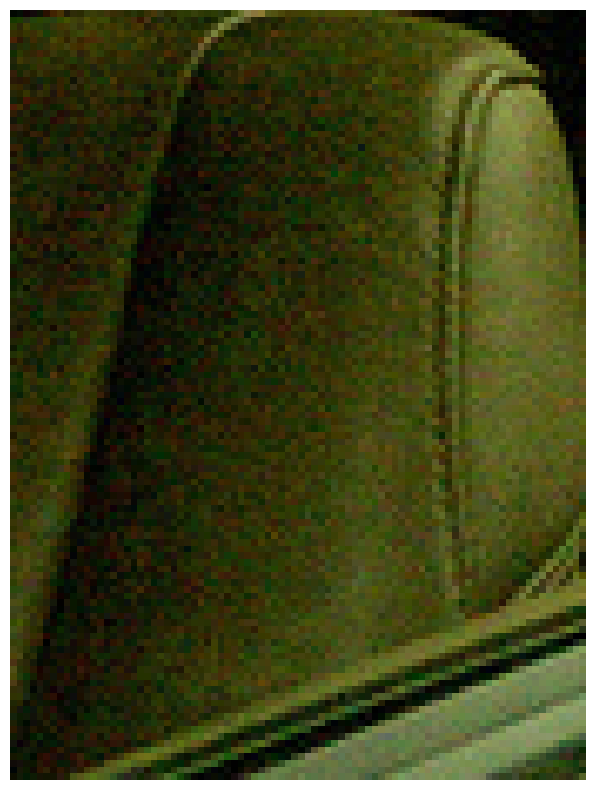

xywh:  [346, 241, 103, 119] lurd:  [346, 241, 449, 360]
label:  18 , dog
score:  0.9945135116577148


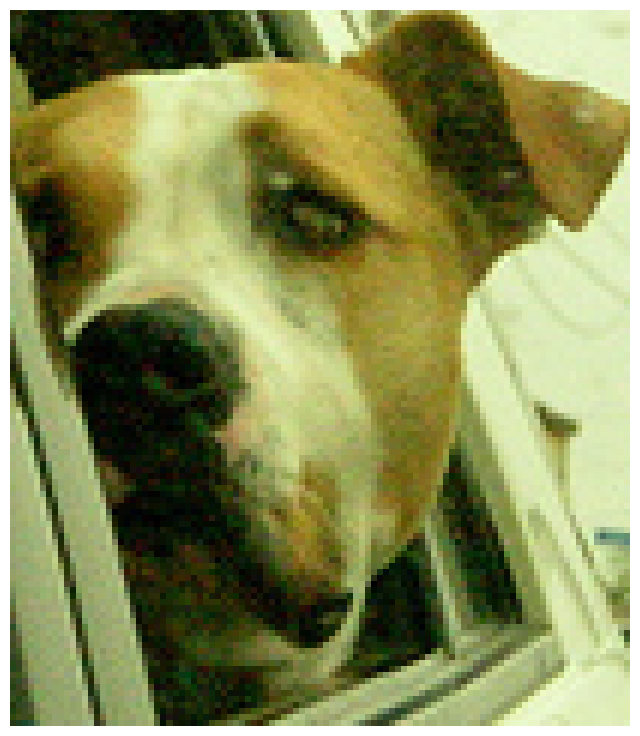

xywh:  [558, 301, 81, 176] lurd:  [558, 301, 639, 477]
label:  39 , baseball bat
score:  0.27483227849006653


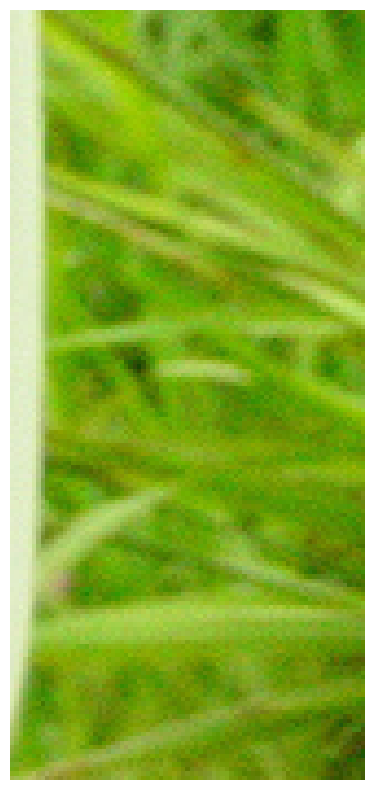

xywh:  [158, 210, 109, 199] lurd:  [158, 210, 267, 409]
label:  62 , chair
score:  0.7477949857711792


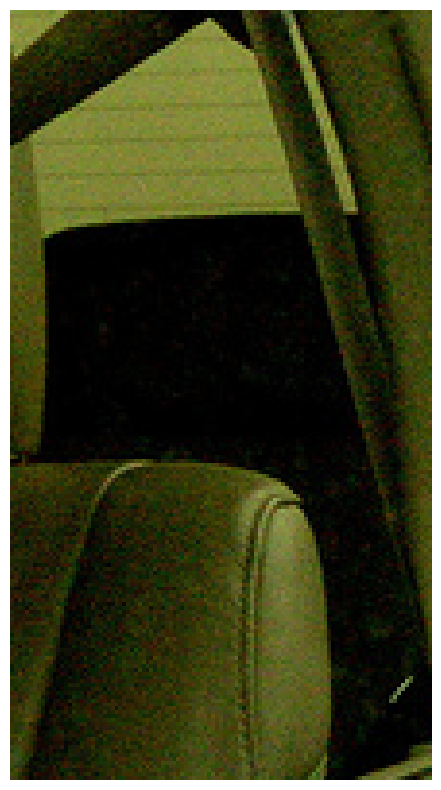

xywh:  [465, 366, 42, 110] lurd:  [465, 366, 507, 476]
label:  32 , tie
score:  0.07239484786987305


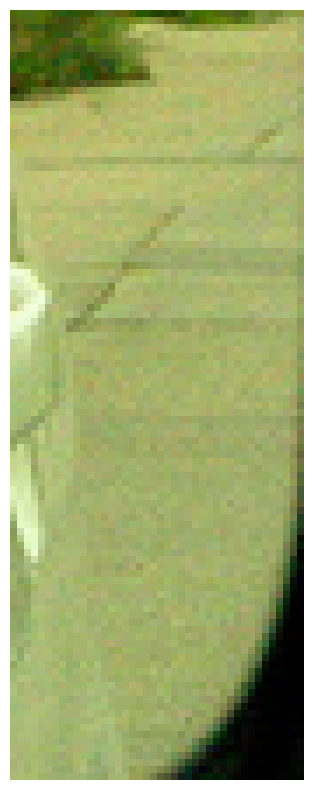

xywh:  [57, 386, 27, 90] lurd:  [57, 386, 84, 476]
label:  10 , traffic light
score:  0.18399953842163086


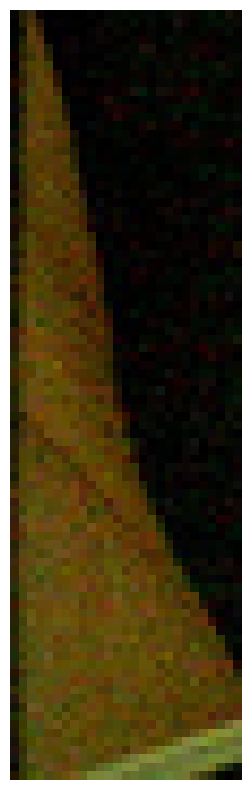

xywh:  [213, 390, 202, 87] lurd:  [213, 390, 415, 477]
label:  3 , car
score:  0.32385191321372986


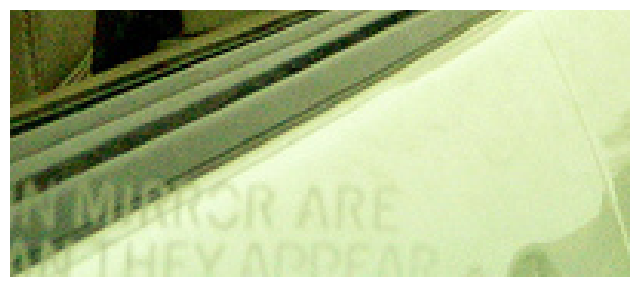

xywh:  [166, 263, 101, 146] lurd:  [166, 263, 267, 409]
label:  62 , chair
score:  0.738706111907959


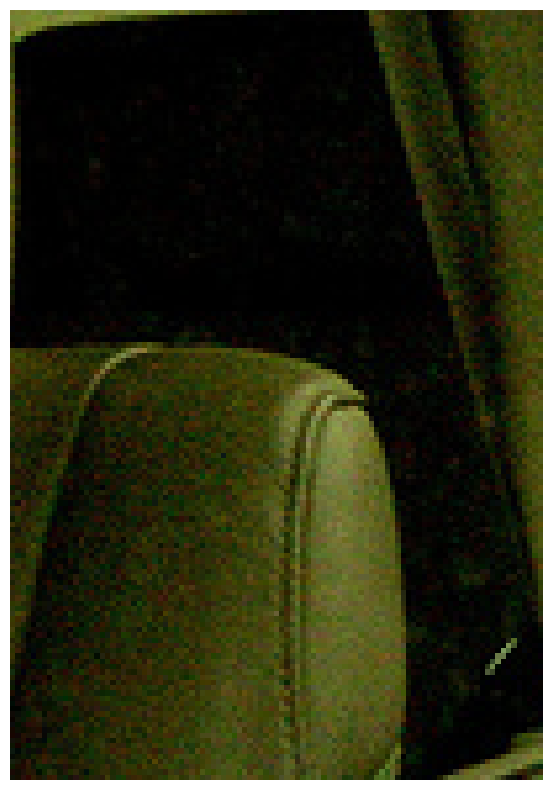

xywh:  [333, 0, 72, 26] lurd:  [333, 0, 405, 26]
label:  56 , broccoli
score:  0.3186907172203064


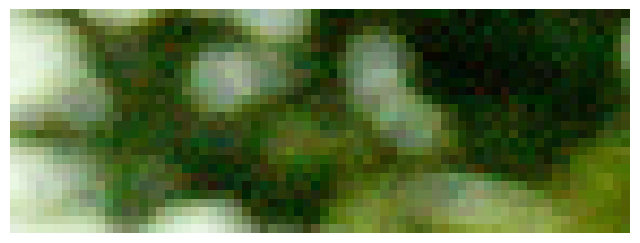

xywh:  [156, 208, 89, 59] lurd:  [156, 208, 245, 267]
label:  38 , kite
score:  0.7352005839347839


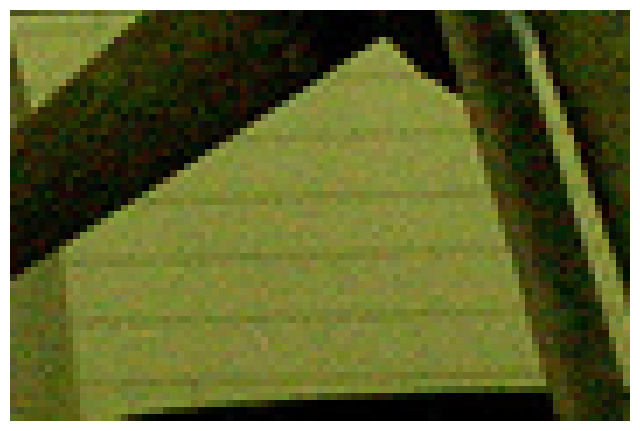

xywh:  [0, 14, 64, 55] lurd:  [0, 14, 64, 69]
label:  50 , spoon
score:  0.1138000562787056


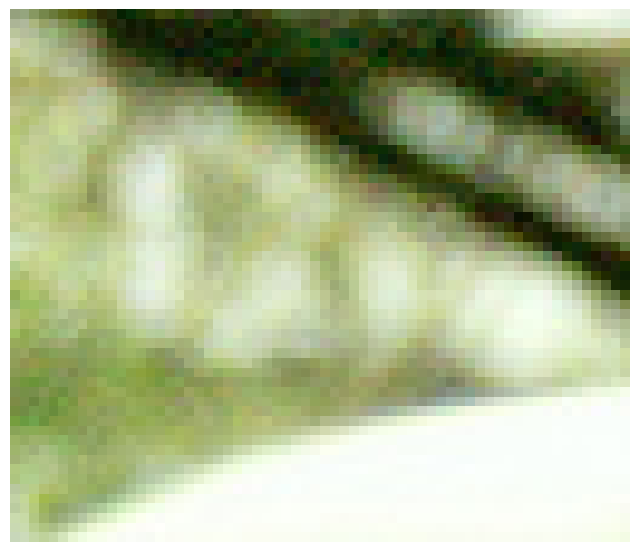

xywh:  [279, 111, 108, 144] lurd:  [279, 111, 387, 255]
label:  42 , surfboard
score:  0.4995710849761963


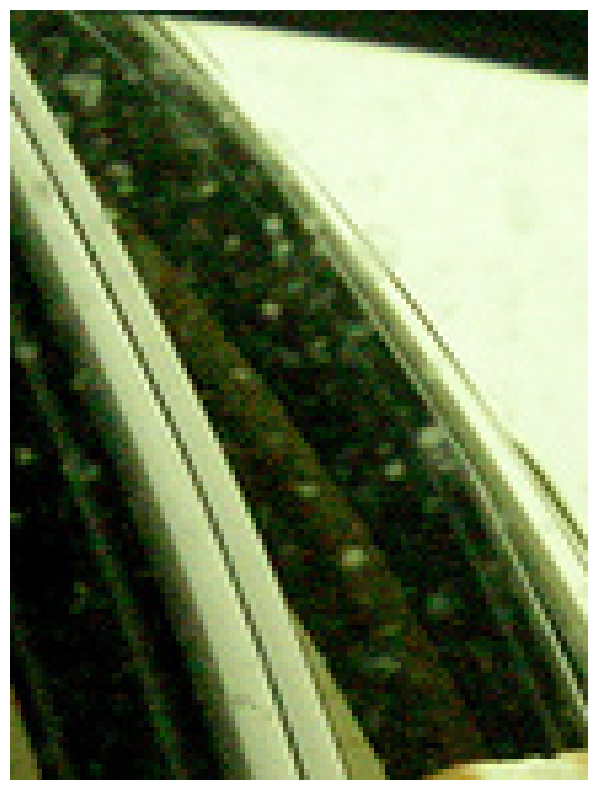

xywh:  [405, 129, 9, 115] lurd:  [405, 129, 414, 244]
label:  53 , apple
score:  0.1025843396782875


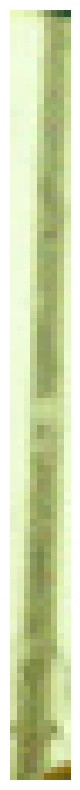

xywh:  [101, 208, 144, 63] lurd:  [101, 208, 245, 271]
label:  38 , kite
score:  0.2555527985095978


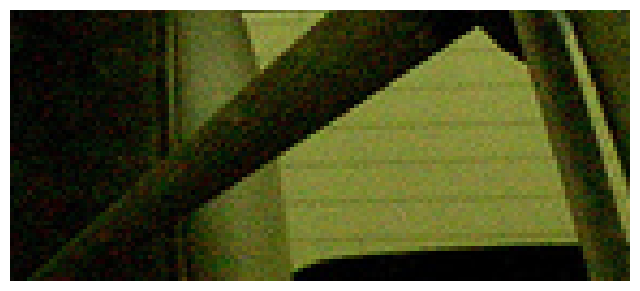

xywh:  [469, 0, 66, 48] lurd:  [469, 0, 535, 48]
label:  17 , cat
score:  0.19043131172657013


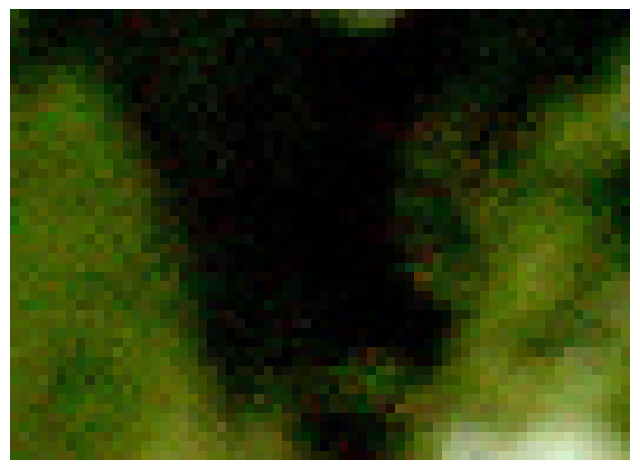

xywh:  [455, 401, 17, 29] lurd:  [455, 401, 472, 430]
label:  52 , banana
score:  0.0979025661945343


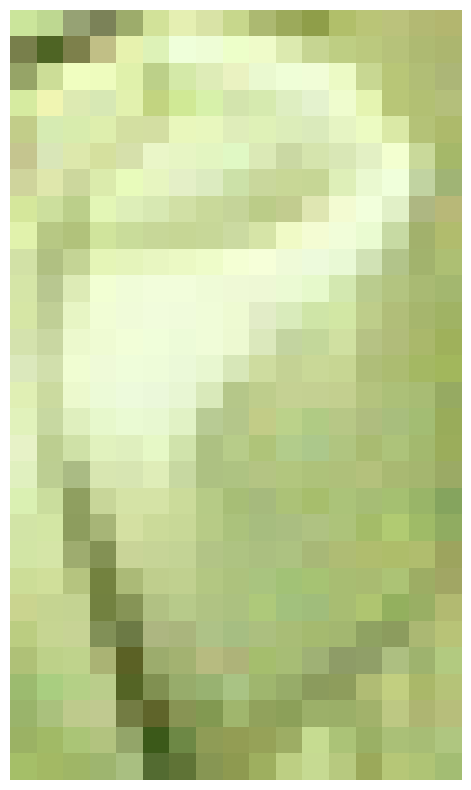

xywh:  [0, 0, 639, 328] lurd:  [0, 0, 639, 328]
label:  18 , dog
score:  0.9644360542297363


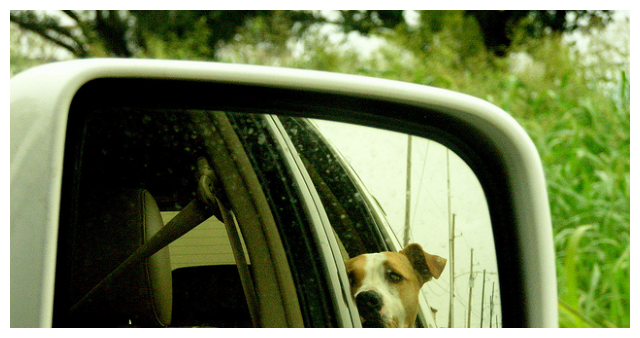

xywh:  [73, 102, 126, 105] lurd:  [73, 102, 199, 207]
label:  1 , person
score:  0.10633566230535507


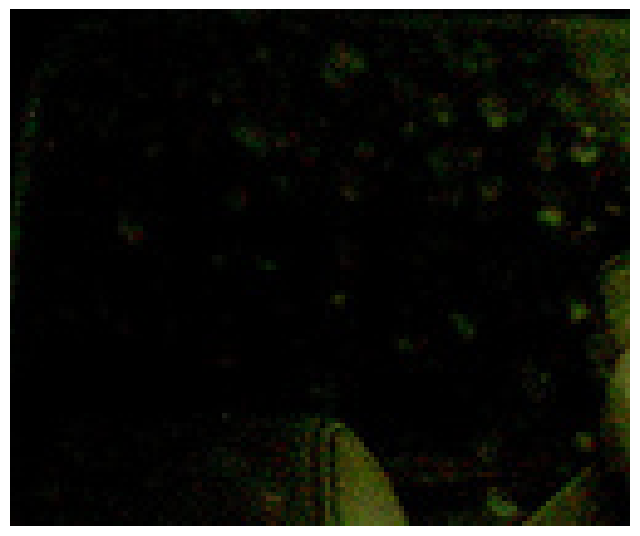

xywh:  [298, 148, 69, 106] lurd:  [298, 148, 367, 254]
label:  42 , surfboard
score:  0.2785031497478485


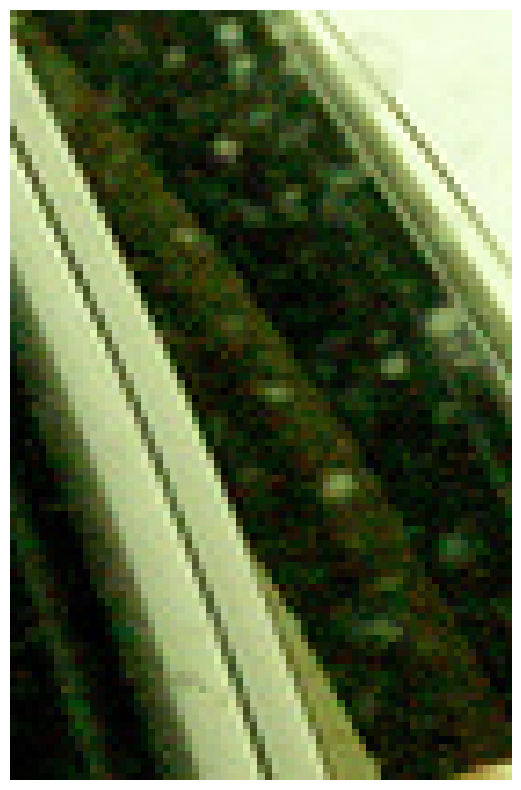

xywh:  [225, 108, 152, 274] lurd:  [225, 108, 377, 382]
label:  18 , dog
score:  0.9545857310295105


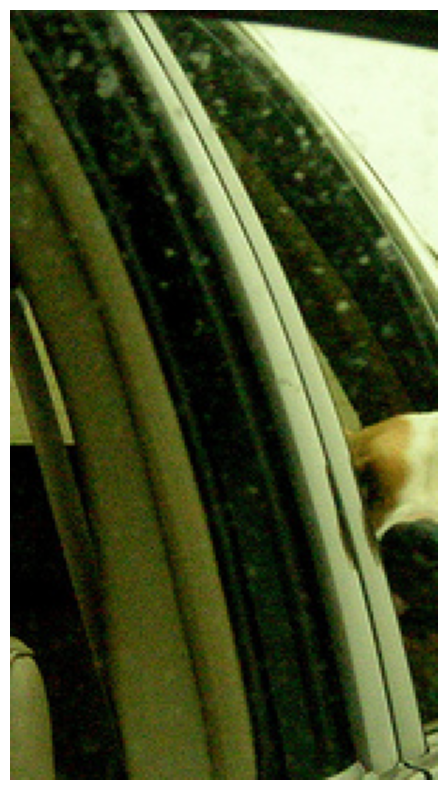

xywh:  [552, 65, 87, 411] lurd:  [552, 65, 639, 476]
label:  90 , toothbrush
score:  0.22480259835720062


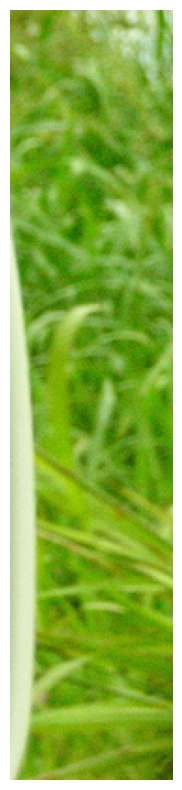

xywh:  [426, 249, 23, 28] lurd:  [426, 249, 449, 277]
label:  52 , banana
score:  0.11019787937402725


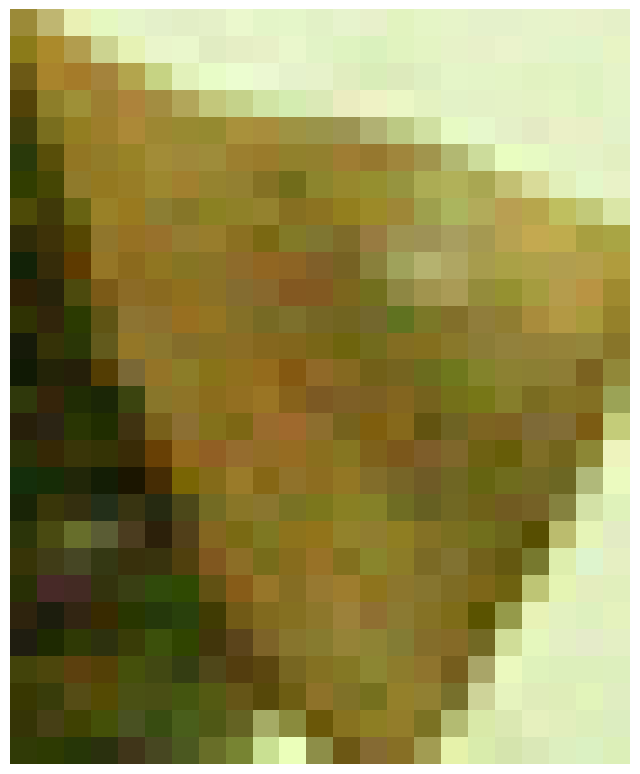

xywh:  [468, 0, 152, 48] lurd:  [468, 0, 620, 48]
label:  56 , broccoli
score:  0.31401723623275757


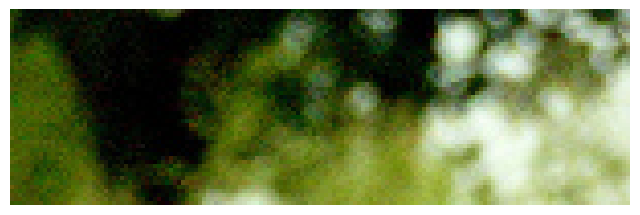

xywh:  [549, 64, 90, 264] lurd:  [549, 64, 639, 328]
label:  64 , potted plant
score:  0.2459307163953781


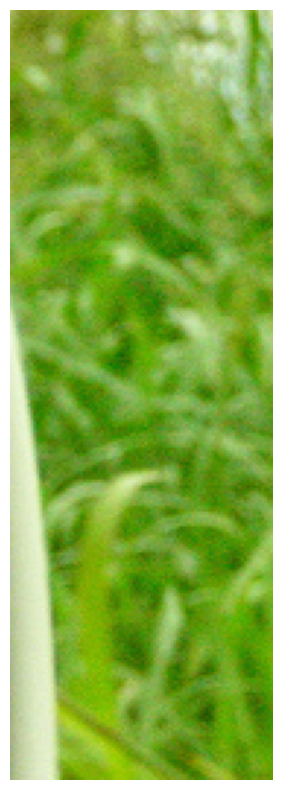

xywh:  [405, 0, 18, 19] lurd:  [405, 0, 423, 19]
label:  1 , person
score:  0.15577735006809235


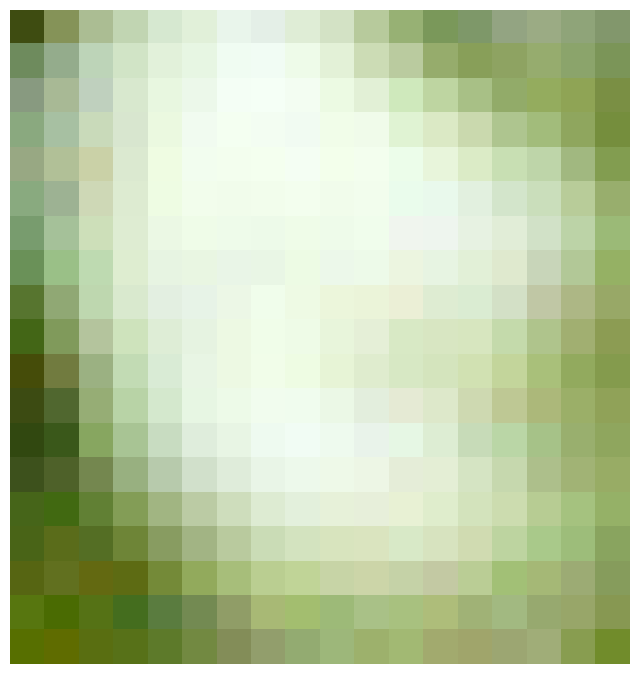

In [29]:
for label in range(len(label_dict)):
    check_label(label)

In [37]:
print(labels_id.get(18))

None


##### Step 5. If label is in COCO: compare prediction with ground truth score using mAP, Else: ignore

In [35]:
# import dependencies for COCO evaluation
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [36]:
annType = ['segm','bbox','keypoints']
annType = annType[1]      #specify type here
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print('Running demo for *%s* results.'%(annType))

Running demo for *bbox* results.


In [37]:
#initialize COCO ground truth api
dataDir='../'
dataType='val2017'
prefix = 'instances'
annFile = '%s/coco/annotations/%s_%s.json'%(dataDir,prefix,dataType)
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=2.53s)
creating index...
index created!


In [53]:
# initialize COCO detections api
resFile='%s/coco/results/%s_%s_fake%s100_results.json'%(dataDir, prefix, dataType, annType)

# save the label_dict to a json file
with open(resFile, 'w') as f:
    json.dump(label_dict_accurate, f)

# load results in COCO evaluation tool    
cocoDt=cocoGt.loadRes(resFile)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [54]:
imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

In [55]:
# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.27s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100